# Bias, variance and generalisation

## Prerequisites
- [Gradient based optimisation]()

This notebook will introduce some core concepts in machine learning including bias, variance and generalisation.

## The data generating, empirical, training and test distributions 

Imagine an unsupervised dataset (with only input features, no output labels), where every datapoint is the height of a person. 
Not all values of height appear in this dataset:
- It is very unlikely to include an example of someone whos height was 3 meters. 
- It is also unlikely to include examples of someone whos height is 0.3 meters.  
- We know that it's impossible for any value to be negative!

Why is this?

They have these heights because naturally, life generates people with these particular dimensions.
Not all heights are distributed to an equal number of people - some heights are more likely than others.
Real examples are sampled from the **data generating distribution**, $p_{data}$.

The values which appear in the dataset are the heights of people who were sampled from the whole population. 
The population contains many people of many different heights.
So the values in our dataset makes up an **empirical distribution**.
That is, this distribution is what we expect the data generating distribution to look like, based on the examples that we sampled.
We hope that this training distribution is **representative** of the data generating distribution.

We can then split our empirically distributed dataset into a training set and a testing set, which define the training distribution, $p_{train}$, and test distribution, $p_{test}$ of our dataset.

![title](images/dists.jpg)

### Another example
Imagine an unsupervised image dataset. Images from the data generating distibution, $p_{data}$ look like something that you actually might see in real life, rather than something random or psychadelic. Our empirical distribution is a subset of these images from the data generating distibution. We then split this dataset into our train and test sets.

![title](images/img-dists.jpg)

### The supervised dataset case

Extending the idea to supervised datasets, the data generating distribution controls the likelihood of any particular input-output pair. The data generating distribution of a dataset of people's heights as inputs and their ages as outputs (for predicting age from height maybe) is very unlikely to generate a pair like $(height=3 \ meters, age=25 \ years)$, but this distribution will define what examples are most likely to be sampled in the empirical distribution of our dataset.

### How classifiers use these distributions to make discrete predictions

Classifiers predict probabilities of an example, $x$, being a member of a particular class, the function which leads to each output is exactly trying to model the data generating distribution for each of those classes, $p_{data}(x)$.

Let's imagine a dataset of hand written digits from 0-9 (the MNIST dataset).
The groups of examples in each class will essentially be their own dataset (e.g. i have a dataset of hand written zeros, ..., and a dataset of handwritten nines). 

Our output will be a vector of probabilities with this many values, where each value represents the model's 
confidence of the example being a member of that class.
There will essentially be 10 datasets of examples from class 0, class 1, ... and class 9.
Each will have its own data generating distribution - all possible examples of a hand drawn 5, which we would never actually be able to collect because there might be an infinite number of ways that it could be drawn). Each dataset will also have its own empirical distribution - the distribution of examples which have actually been collected in the dataset.

![title](images/classifier.jpg)

### How regression models use these distributions to make continuous predictions

Regression models predict continuous values from a supervised dataset. Unlike classification models, they do not predict the probability of the input being a member of some class. Rather, they predict the most likely value to be sampled from a Gaussian probability distribution over that input variable taking that particular value, and then output the most likely value to be sampled from that distribution as a prediction (see more in the [maximum likelihood notebook]())

![title](images/regression.jpg)

## Bias & underfitting

When we train our models, we need to make sure that they are being optimised for the right thing.

If we try to fit a curve with a straight line, the line's parameters may converge to values that produce the minimum loss (best fit). But it certainly wont actually represent the curved input-output relationship that we need. 

Let's look at that. Run the cell below to create a linear model and optimise its parameters using gradient descent to best fit a cubic function.

X: [-2.51020408 -0.79591837 -3.        ] 

Y: [-47.45132555  -1.51260954 -81.        ] 

[[-2.51020408]
 [-0.79591837]
 [-3.        ]]


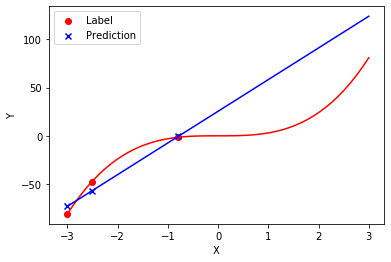

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial import Polynomial

class MultiVariableLinearHypothesis:
    def __init__(self, n_features):
        self.n_features = n_features
        self.b = np.random.randn()
        self.w = np.random.randn(n_features)
    def __call__(self, X): #input is of shape (n_datapoints, n_vars)
        y_hat = np.matmul(X, self.w) + self.b
        return y_hat #output is of shape (n_datapoints, 1)
    def update_params(self, new_w, new_b):
        self.w = new_w
        self.b = new_b
    def calc_deriv(self, X, y_hat, labels):
        diffs = y_hat-labels
        dLdw = 2 * np.array([np.sum(diffs * X[:, i]) / m for i in range(self.n_features)])                          
        dLdb = 2 * np.sum(diffs)/m
        return dLdw, dLdb
                           
def train(num_epochs, X, Y, H):
    for e in range(num_epochs): # for this many complete runs through the dataset
        y_hat = H(X) # make predictions
        dLdw, dLdb = H.calc_deriv(X, y_hat, Y) # calculate gradient of current loss with respect to model parameters
        new_w = H.w - learning_rate * dLdw # compute new model weight using gradient descent update rule
        new_b = H.b - learning_rate * dLdb # compute new model bias using gradient descent update rule
        H.update_params(new_w, new_b) # update model weight and bias
                           
def create_polynomial_inputs(X, order=3):
    new_dataset = np.array([X, *[np.power(X, i) for i in range(2, order + 1)]]).T
    return new_dataset # new_dataset should be shape [m, order]
            
_range = 3
data = np.linspace(-_range, _range, 50) # 

m = 3 # how many examples do we want?
X = np.random.choice(data, size=(m,))
true_coeffs = (0, 0, 0, 3)
Y_fn = np.polynomial.polynomial.Polynomial(true_coeffs)
Y = Y_fn(X)
print('X:',X, '\n')
print('Y:',Y, '\n')   

num_epochs = 1000
learning_rate = 0.01
highest_order_power = 1

x_data = create_polynomial_inputs(X, highest_order_power) # create polynomial 
print(x_data)
H = MultiVariableLinearHypothesis(n_features=highest_order_power) # initialise our model
    
train(num_epochs, x_data, Y, H) # train model and plot cost curve

fig = plt.figure()
plt.scatter(X, Y, c='r', label='Label')
plt.plot(data, Y_fn(data), c='r')
plt.scatter(X, H(x_data), c='b', label='Prediction', marker='x')
plt.plot(data, H(data.reshape(len(data), 1)), c='b')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In this case, our model is biased to modelling a linear function, when in reality the true function is not linear, it's curved.

### What is bias?
Bias is defined as the expected difference between the parameters that we learn, and the true parameters that define the data generating function.

![title](images/NN1_bias.JPG)

### Underfitting - what's wrong with bias

Biased models are not optimising for the right thing. Even their best parameterisation based on the objective will not be optimal. Bias is a result of a model not having a high enough capacity to represent the function necessary.

### Symptoms of bias
- model training loss plateaus
- test performance stops improving with more training

![title](images/bias-syms.jpg)

### What can we do about bias?
- Use a model with a greater capacity
- Change our objective function

### Visualising bias

Of course in real life we have no way to know the parameters of the data generating function, but in this case we defined that function and we do know them - so we can quantitatively calculate the bias as an example.

![title](images/computing-bias.jpg)

Let's run the code cell below to compute the bias of our model (remember we can only do this because we made the fake data and know it's true parameterisation).

In [2]:
params = np.array([np.append(H.b, H.w)])

def compute_bias(my_params, true_params):
    """Compares your model's parameter vector with the data generating parameter vector and computes the bias in the model"""
    
    # MAKE PARAM VECTORS THE SAME LENGTH SO THE MATH WORKS
    if my_params.shape[1] < len(true_params): # if my model doesnt have as many params as the true model
        my_params = np.append(my_params, np.zeros((my_params.shape[0], len(true_params) - my_params.shape[1])), axis=1) # pad it with zeros (assuming that the n parameters i have are coefficients of same features that the first n parameters in the data generating function multiply)
    elif my_params.shape[1] > len(true_params): # if my model has more params than are in the data generating function
        true_params = np.append(true_params, np.zeros((1, my_params.shape[1] - len(true_params)))) # pad the true params with zeros so the shape matches
    
    # COMPUTE BIAS BETWEEN PARAM VECTORS
    diffs = my_params - true_params ## compute difference between parameter vectors
    bias = np.mean(diffs) ## compute mean bias
    bias = np.abs(bias) ## we want the absolute values which tell us whether the model is biased or not, regardless of in which direction
    return bias

bias = compute_bias(params, true_coeffs)
print('BIAS:', bias)
    

BIAS: 13.830361026593687


## Variance & overfitting

Sometimes, we have the opposite problem to high bias - high variance. That is, our model has the capacity to model way more complex funtions than necessary. This means that it can easily fit all the training examples perfectly, and furthermore that it can find many ways to do this - the variance of the different acceptable parameterisations is high. 

![title](images/NN1_variance.JPG)

### Overfitting - what's bad about variance

Variance occurs because there are many possible acceptable parameterisations. Many of these will not model the function that we want and only perform well for the examples that they were trained on, rather than all possible inputs. That means that higher variance leads to worse generalisation. Variance makes our models **overfit** to the data that they were trained on.

### Symptoms of variance
- training loss continues to decrease but testing loss increases

![title](images/var-syms.jpg)

### What can we do about high variance?

- Reduce the capacity of our model
- Increase the size of our dataset
- Introduce regularization into our loss function. We cover regularisation [in this notebook](http://theaicore.com/app/training/regularisation).

### Visualising variance

Again, in practice it's very unlikely that we ever actually know the parameterisation of the data generating distribution. We only know in this case because we made it ourselves. But because we do know it right now, we can actually estimate the variance of this model as a demonstration! 

The code below trains several models and then plots the function that they represent. You should see that each of the function fits the training examples well, but that they are all different. This highlights the variance in different acceptable models. The code also computes and prints the variance

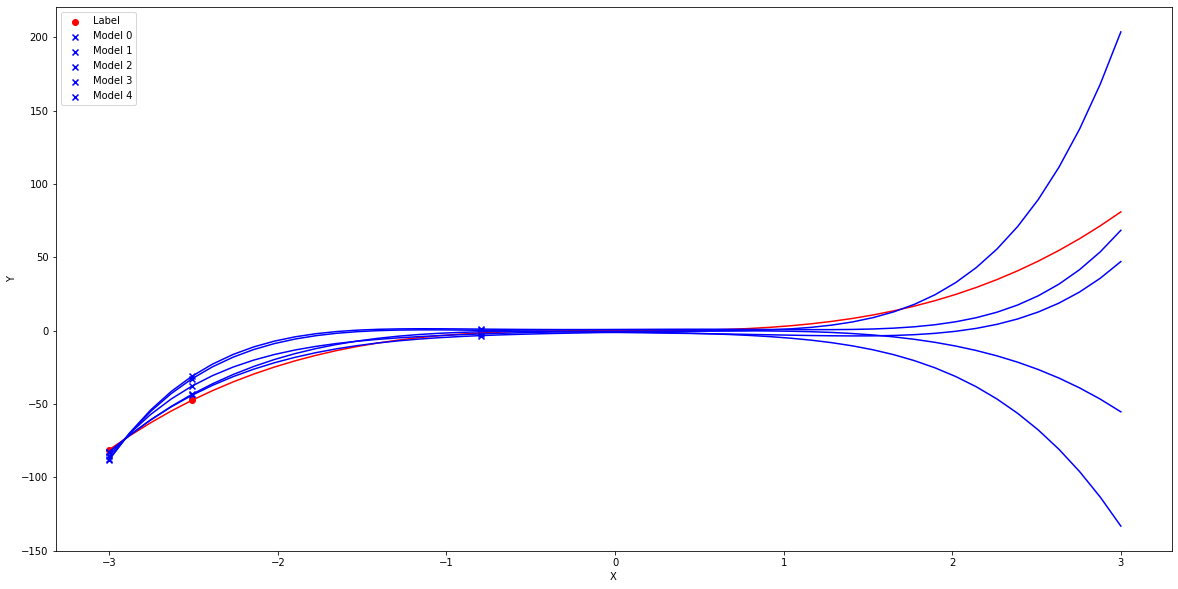

Variance: -1.3877787807814457e-17


In [3]:
num_epochs = 10000
learning_rate = 0.000001
highest_order_power = 5

x_poly = create_polynomial_inputs(X, highest_order_power) # create polynomial 

fig = plt.figure(figsize=(20, 10))
plt.scatter(X, Y, c='r', label='Label')
plt.plot(data, Y_fn(data), c='r')
plt.xlabel('X')
plt.ylabel('Y')

colors = ['b', 'g', 'k', 'y']
    
def train_n_models(order, n_models=5, plot=True):
    params = []
    for i in range(n_models): # train this many models
        H = MultiVariableLinearHypothesis(n_features=order) ## initialise our model with num powers of x = order
        train(num_epochs, x_poly, Y, H) ## train model and plot cost curve
        params.append(np.append(H.b, H.w))
        if plot:
            plt.scatter(X, H(x_poly), c='b', label=f'Model {i}', marker='x')
            plt.plot(data, H(create_polynomial_inputs(data, order)), c='b')
    if plot:
        plt.legend()
        plt.show()
    return np.array(params)

def compute_variance(all_params):   
    avg_params  = np.mean(all_params, axis=0) ## compute average resulting parameters
    diffs = all_params - avg_params ## broadcast subtraction of avg params
    variance = np.mean(diffs) ## compute mean squared 
    return variance

params = train_n_models(highest_order_power)
v = compute_variance(params)
print('Variance:', v)

# might need to run the code a few times to show models with an obvious variance

As you can see, all of these functions pass through the datapoints in the training set (where circles are plotted). They fit them almost perfectly! But they do not actually represent the true input-output relationship, especially further away from examples that were seen in the training set.

## Let's compare bias, variance and generalisation for different models

Bias and variance measure two different sources of error in a model's parameterisation:
- Bias - measures the error that you expect from the true parameterisation
- Variance - measures the expected difference of a particular parameterisation from the averagely found parameterisation. This is a result of the particular subset of all possible examples which makes up the dataset that the model was trained on.

# bias vs variance grid comparison?
![title](images/b-v-grid.jpg)

## Trading off bias and variance

### Testing generalisation theoretically

#### Mean squared error = bias$^2$ + variance
$MSE = \mathbb{E}[( \hat{\theta}_m - \theta )^2] = Bias(\hat{\theta}_m)^2 + Var(\hat{\theta}_m)$

The mean squared error of a parameter estimate can be expressed as the sum of the bias squared and the variance. As such, it is a suitable way to evaluate the optimal capacity of a model. However, as mentioned repeatedly, we need to know the true parameterisation of the data generating function to compute the bias and variance and hence the MSE - **so this cannot be done in practice**

The code below trains multiple polynomial models which include terms for successively larger powers of x. For each, we calculate the bias and variance using the (usually unknown) true parameterisation of the data generating function. We will train each of these model several times to get an average. We also plot the MSE here.

order:  1
order:  2
order:  3
order:  4
order:  5
order:  6
order:  7
order:  8


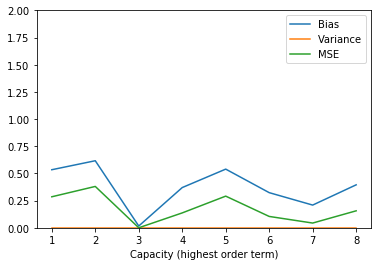

In [26]:
poly_orders = 9
num_models = 5

all_parameters = [] # will use this in the next code cell

orders = list(range(1, poly_orders))
biases = []
variances = []
for order in orders:
    print('order: ', order)
    if order > 1:
        x_poly = create_polynomial_inputs(X, order) # create polynomial 
    else:
        x_poly = X.reshape(-1, 1)
    parameters = train_n_models(order, n_models=num_models, plot=False)
    biases.append(compute_bias(parameters, true_coeffs))
    variances.append(compute_variance(parameters))
    
    all_parameters.append(parameters) # will use this in the next code cell
    
plt.plot(orders, biases, label='Bias')
plt.plot(orders, variances, label='Variance')
plt.plot(orders, np.sum([variances, np.array(biases)**2], axis=0), label='MSE')
plt.xlabel('Capacity (highest order term)')
plt.ylim(0, 2)
plt.legend()
plt.show()

The graph above should show that the model with the minimum mean squared error in the estimate of the true parameters is that which includes x-terms up to $x^3$. This indicates that we should use a cubic model, which makes sense beacause we created our data from a cubic function.

If we smoothed the above graph it should look something like that shown below.

![title](images/g-gap.jpg)

### Testing Generalisation in practice

We build machine learning algorithms to make predictions. The real measure of success in machine learning is when we can make correct predictions for samples that the model has not seen yet.

We already know that models with high bias or high variance aren't good because they either underfit or overfit the data. This means that they will not **generalise** to perform well on new examples - they have high **generalisation error**.

Because the mean squared error incorporates both bias and variance, it should be a measure of this generalisation error.

Let's add to the above code to not only train the models but also to compute their generalisation ability.

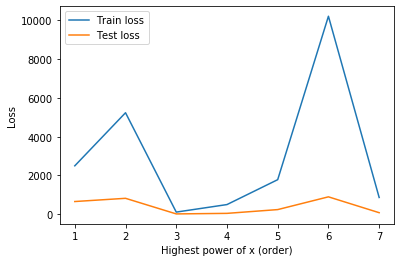

In [19]:
def Loss(y_hat, y):
    return np.sum((y_hat - y)**2) / len(y_hat)

def train_and_test(params_list):
    train_data = np.random.choice(data, size=(3,)) # randomly sample from data
    test_data = np.random.choice(data, size=(100,))
    train_losses = []
    test_losses = []

    for order, params in enumerate(params_list): # for each of the previously trained parameters

        # params = np.mean(params, axis=0) # compute mean of parameters predicted for this model
        params = params[0] # or just use the first one

        h = np.polynomial.polynomial.Polynomial(params) # create polynomial function

        h_train = h(train_data) # make prediction on training data
        train_loss = Loss(h_train, Y_fn(train_data)) # compute training loss
        train_losses.append(train_loss)

        h_test = h(test_data) # make prediction on test data
        test_loss = Loss(h_test, Y_fn(test_data)) # compute test loss
        test_losses.append(test_loss)

    plt.plot(orders, train_losses, label='Train loss')
    plt.plot(orders, test_losses, label='Test loss')
    plt.legend()
    plt.xlabel('Highest power of x (order)')
    plt.ylabel('Loss')
    plt.show()
        
        
train_and_test(all_parameters)

You should see that the test loss is best (lowest) for the cubic model. Again this makes sense, as our data generating function is cubic.

## You've completed the notebook!

You should now understand what we mean when we talk about our model's bias or vaiance in machine learning. You should also be able to diagnose when either of these are the problem and know how to remedy them. You should also understand what it means for our model to be able to generalise.